# Delivery Time Prediction



## Load data from files

In [1]:
import json


deliveriesFile = open("IUM21L_Zad_02_02/deliveries.jsonl", "r")
productsFile = open("IUM21L_Zad_02_02/products.jsonl", "r")
sessionsFile = open("IUM21L_Zad_02_02/sessions.jsonl", "r")
usersFile = open("IUM21L_Zad_02_02/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

print(deliveries[0].keys())
print(products[0].keys())
print(sessions[0].keys())
print(users[0].keys())

dict_keys(['purchase_id', 'purchase_timestamp', 'delivery_timestamp', 'delivery_company'])
dict_keys(['product_id', 'product_name', 'category_path', 'price'])
dict_keys(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id'])
dict_keys(['user_id', 'name', 'city', 'street'])


## Analyse data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
products.sort(key=lambda product : product["price"])
print("Price \t Product")
for product in products:
    print(str(product["price"])+"\t"+product["product_name"])

Price 	 Product
-249.0	Plantronics Voyager Legend
-89.99	Dead Space 3 (Xbox 360)
-89.99	Mortal Kombat (Xbox 360)
-55.9	Warhammer 40.000 Dawn of War Winter Assault (PC)
-47.7	Symulator Robót Drogowych (PC)
-34.99	Lego Harry Potter Lata 5-7 (PC)
-34.9	The Sims 3 Wymarzone Podróże (PC)
-32.99	Call of Duty Modern Warfare 3 (PC)
-25.9	S.T.A.L.K.E.R. Cień Czarnobyla (PC)
-14.99	Anarchy Reigns (Xbox 360)
1.0	Król Futbolu Piłkarski Quiz (PC)
1.0	Heroes Over Europe (PC)
1.0	The Ball (PC)
1.99	Street Fighter 4 (PC)
3.0	Dragonshard (PC)
3.59	Hearts of Iron 2 (PC)
4.9	Dream Pinball 3D (PC)
4.99	Cities in Motion (PC)
4.99	A New Beginning (PC)
4.99	Rig&#39;n&#39;Roll Tirowiec (PC)
4.99	Symulator Kamieniołomu (PC)
4.99	Men of War Oddział Szturmowy (PC)
5.0	Symulator Zamiatarki ulic (PC)
7.9	Warhammer 40.000 Space Marine (PC)
8.9	Singularity (PC)
8.99	MAJESTY ANTOLOGIA (PC)
8.99	Euro Truck Simulator (PC)
9.9	Mad Riders (PC)
9.99	Bus Driver (PC)
9.99	King&#39;s Bounty Nowe Światy (PC)
9.99	Hard Reset (

265 purchases not delivered
5103 purchases delivered
0 packages delivered before purchase


Text(0.5, 0, 'Delivery duration')

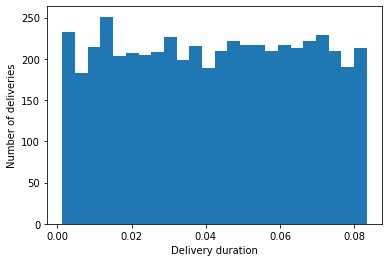

In [4]:
from datetime import datetime
import time

notDeliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is None]
deliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is not None]
print(str(len(notDeliveredList))+" purchases not delivered")
print(str(len(deliveredList))+" purchases delivered")

deliveryTimes = [datetime.strptime(delivery['delivery_timestamp'], "%Y-%m-%dT%H:%M:%S") for delivery in deliveredList]
purchaseTimes = [datetime.strptime(delivery['purchase_timestamp'], "%Y-%m-%dT%H:%M:%S") for delivery in deliveredList]

counter = 0
for dt, pt in zip(deliveryTimes, purchaseTimes):
    if dt < pt:
        counter += 1  
print(str(counter)+" packages delivered before purchase")

deliveryDurations = [(deliveryTime - purchaseTime).seconds/3600 if deliveryTime > purchaseTime else (deliveryTime - purchaseTime).seconds/3600*(-1) for deliveryTime, purchaseTime in zip(deliveryTimes, purchaseTimes)]

plt.hist(deliveryDurations, density=False, bins=24)
plt.ylabel('Number of deliveries')
plt.xlabel('Delivery duration')